In [5]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import h5py
import seaborn as sns
import pandas as pd
from scipy.stats import pearsonr
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from predify.utils.training import train_pcoders, eval_pcoders

from networks_2022 import BranchedNetwork
from data.CleanSoundsDataset import CleanSoundsDataset

/home/es3773/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# Choose which network you're running

In [6]:
args = ['all', 'a1']

# Parameters

In [7]:
engram_dir = '/mnt/smb/locker/issa-locker/users/Erica/'

In [8]:
fig_dir = f'{engram_dir}hcnn/figures/'
pickle_dir = f'{engram_dir}hcnn/pickles/'
activations_dir = f'{engram_dir}hcnn/activations/'

In [9]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Device: {DEVICE}')

checkpoints_dir = f'{engram_dir}hcnn/checkpoints/'
tensorboard_dir = f'{engram_dir}hcnn/tensorboard/'

Device: cuda:0


# Helper functions

In [10]:
def load_pnet(PNetClass, pnet_name, chckpt):
    net = BranchedNetwork(track_encoder_representations=True)
    net.load_state_dict(torch.load(f'{engram_dir}networks_2022_weights.pt'))
    pnet = PNetClass(net, build_graph=False)
    pnet.load_state_dict(torch.load(
        f"{checkpoints_dir}{pnet_name}/{pnet_name}-{chckpt}-regular.pth",
        map_location='cpu'
        ))
    pnet.to(DEVICE)
    pnet.eval();
    print(f'Loaded Pnet: {pnet_name}')
    print_hps(pnet)
    return pnet

In [11]:
def print_hps(pnet):
    for pc in range(pnet.number_of_pcoders):
        print (f"PCoder{pc+1} : ffm: {getattr(pnet,f'ffm{pc+1}'):0.3f} \t fbm: {getattr(pnet,f'fbm{pc+1}'):0.3f} \t erm: {getattr(pnet,f'erm{pc+1}'):0.3f}")

In [12]:
# A few distance metrics

def row_rms(A, B):
    """
    RMS across rows
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    
    if len(A.shape) == 1:
        stim = A - B
        return np.sqrt(np.mean(stim * stim, axis = 0))
    
    rmses = []
    for idx in range(A.shape[0]):
        a = A[idx]
        b = B[idx]
        a, b = a.T, b.T
        stim = (a - b)
        out = np.sqrt(np.mean(stim * stim, axis = 0))
        rmses.append(out)
    return np.mean(rmses)

def rms(A, B):
    """
    RMS of flattened vectors
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
        
    stim = A - B
    out = np.sqrt(np.mean(stim * stim))

    return out

def tanimoto_distance(A, B):
    """
    Tanimoto distance of flattened vector
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
    
    _out = np.dot(A, B)/(np.linalg.norm(A)**2 + np.linalg.norm(B)**2 - np.dot(A,B))
    return _out
    
def cosine_similarity(A, B):
    """
    Cosine similarity of flattened vector
    """
    
    if torch.is_tensor(A):
        A = A.numpy()
    if torch.is_tensor(B):
        B = B.numpy()
    A = A.astype(float)
    B = B.astype(float)
    A = A.flatten()
    B = B.flatten()
    
    if len(A.shape) == 1:
        return np.dot(A, B)/(np.linalg.norm(A)*np.linalg.norm(B))
    
    out = []
    for channel in range(n_channels):
        a = A[channel]
        b = B[channel]
        _out = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        if np.isnan(_out):
            print(f'nan: {np.linalg.norm(a)}, {np.linalg.norm(b)}')
            _out = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)+1E-5)
        out.append(_out)

    return np.mean(out)

# Load PsychoPhysics Dataset

In [13]:
f_in = h5py.File(f"{engram_dir}PsychophysicsWord2017W_not_resampled.hdf5", 'r')

In [14]:
f_metadata = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META.npy", 'r')

In [15]:
f_key = np.load(f"{engram_dir}PsychophysicsWord2017W_999c6fc475be1e82e114ab9865aa5459e4fd329d.__META_key.npy", 'r')

In [16]:
with open(f"{engram_dir}PsychophysicsWord2017W_net_performance.p", 'rb') as f:
    net_mistakes = pickle.load(f)['net_mistakes']

In [17]:
def getPsychophysics2017WCleanCochleagrams():
    
    cochleagrams_clean = []
   
    cochleagrams = []
    for batch_ii in range(0,15300,100):
        hdf5_path = '/mnt/smb/locker/issa-locker/users/Erica/cgrams_for_noise_robustness_analysis/PsychophysicsWord2017W_clean/batch_'+str(batch_ii)+'_to_'+str(batch_ii+100)+'.hdf5'
        with h5py.File(hdf5_path, 'r') as f_in:
            cochleagrams += list(f_in['data'])

    return cochleagrams
clean_in = getPsychophysics2017WCleanCochleagrams()

In [18]:
labels = []
for word in f_metadata['word']:
    idx = np.argwhere(f_key == word)
    if len(idx) == 0:
        labels.append(-1)
    else:
        labels.append(idx.item())
labels = np.array(labels)
labels += 1

In [19]:
bg = []
for _bg in f_metadata['bg']:
    bg.append(str(_bg, 'utf-8'))
bg = np.array(bg)

In [20]:
snr = []
for _snr in f_metadata['snr']:
    _snr = str(_snr, 'utf-8')
    if 'inf' in _snr:
        _snr = np.inf
    elif 'neg' in _snr:
        if '3' in _snr:
            _snr = -3
        elif '6' in _snr:
            _snr = -6
        elif '9' in _snr:
            _snr = -9
        else:
            raise ValueError('Not found')
    else:
        if '0' in _snr:
            _snr = 0
        elif '3' in _snr:
            _snr = 3
        else:
            raise ValueError('Not found')
    snr.append(_snr)
snr = np.array(snr)

In [21]:
orig_dset = []
for _orig_dset in f_metadata['orig_dset']:
    _orig_dset = str(_orig_dset, 'utf-8')
    _orig_dset = 'WSJ' if 'WSJ' in _orig_dset else 'Timit'
    orig_dset.append(_orig_dset)
orig_dset = np.array(orig_dset)

# Background noise for the whole dataset

In [22]:
# This is bad practice! But the warnings are real annoying
import warnings
warnings.filterwarnings("ignore")

In [23]:
import pickle
with open('15_layer_denoising_shuffle.p', 'rb') as f:
    shuffle_results = pickle.load(f)

In [35]:
def get_df(results, distance_func, keep_idxs=None, ts=[0], shuffle_results=None):
    timesteps = []
    distances = []
    encoders = []
    encoder_depths = []
    clean_accs = []
    timestep_accs = []
    final_accs = []
    idxs = []
    
    for idx in results.keys():
        if (keep_idxs is not None) and (not keep_idxs[idx]):
            continue
        clean_output = results[idx]['clean_output']
        clean_repr_dict = results[idx]['clean_repr_dict']
        clean_acc = clean_output == labels[idx]
        timestep_results = results[idx]['timestep_results']
        
        base_distance = {}
        final_acc = timestep_results[4.0]['noisy_output'] == labels[idx]
        for timestep in ts:
            noisy_output = timestep_results[timestep]['noisy_output']
            noisy_repr_dict = timestep_results[timestep]['noisy_repr_dict']
            timestep_acc = noisy_output == labels[idx]
            enc_names = ['conv1', 'conv2', 'conv3', 'conv4_W', 'conv5_W', 'fc6_W']
            for enc_depth, enc_name in enumerate(enc_names):
                noisy_repr = noisy_repr_dict[enc_name]
                clean_repr = clean_repr_dict[enc_name]
                distance = distance_func(noisy_repr, clean_repr)
                if shuffle_results is not None:
                    distance /= shuffle_results[enc_depth][0.0]
                timesteps.append(timestep)
                distances.append(distance)
                encoders.append(enc_name)
                encoder_depths.append(enc_depth)
                clean_accs.append(clean_acc)
                timestep_accs.append(timestep_acc)
                final_accs.append(final_acc)
                idxs.append(idx)
                        
    df = pd.DataFrame({
        'Timesteps': timesteps,
        'Distance Metric': distances,
        'Encoder': encoders,
        'Encoder Depth': encoder_depths,
        'Clean Accuracy': clean_accs,
        'Timestep Accuracy': timestep_accs,
        'Final Accuracy': final_accs,
        'Idx': idxs
    })
    return df

# Dataset Details
We are measuring Cosine Similarity ONLY when Clean Accuracy is True

## FF incorrect, predictive got correct, SHUFFLE CORRECTED

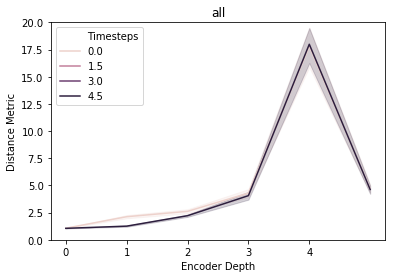

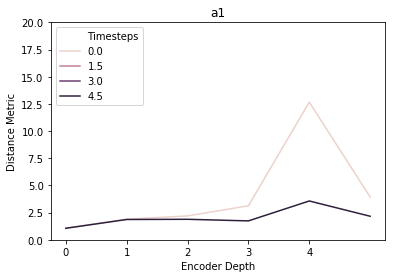

In [37]:
for pnet_name in args:
    pfiles = [
        k for k in os.listdir(
            activations_dir) if k.startswith(pnet_name)
        ]
    dfs = []
    for pfile in pfiles:
        with open(f'{activations_dir}{pfile}', 'rb') as f:
            results = pickle.load(f)
        dfs.append(get_df(
            results, cosine_similarity,
            keep_idxs=net_mistakes,
            ts=[0, 4], shuffle_results=shuffle_results[pnet_name]
            ))
    df = pd.concat(dfs)
    
    fig, ax = plt.subplots()
    g = sns.lineplot(
        x='Encoder Depth', y='Distance Metric', hue='Timesteps',
        data=df[(df['Clean Accuracy'] == True) & (df['Final Accuracy'] == True)]
        )
    plt.xticks([0, 1, 2, 3, 4])
    plt.ylim(0, 20)
    plt.title(pnet_name)
    #plt.axhline(1, color='gray', linestyle='--')
    plt.show(g)

## FF incorrect, predictive got incorrect, SHUFFLE CORRECTED

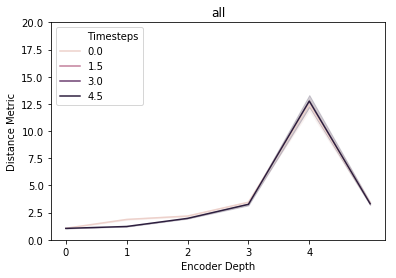

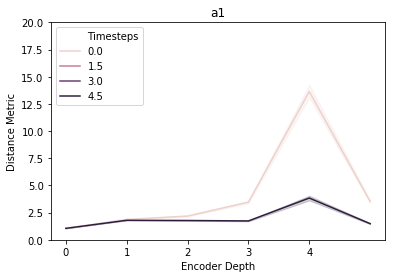

In [38]:
for pnet_name in args:
    pfiles = [
        k for k in os.listdir(
            activations_dir) if k.startswith(pnet_name)
        ]
    dfs = []
    for pfile in pfiles:
        with open(f'{activations_dir}{pfile}', 'rb') as f:
            results = pickle.load(f)
        dfs.append(get_df(
            results, cosine_similarity,
            keep_idxs=net_mistakes,
            ts=[0, 4], shuffle_results=shuffle_results[pnet_name]
            ))
    df = pd.concat(dfs)
    
    fig, ax = plt.subplots()
    g = sns.lineplot(
        x='Encoder Depth', y='Distance Metric', hue='Timesteps',
        data=df[(df['Clean Accuracy'] == True) & (df['Final Accuracy'] == False)]
        )
    plt.xticks([0, 1, 2, 3, 4])
    plt.ylim(0, 20)
    plt.title(pnet_name)
    #plt.axhline(1, color='gray', linestyle='--')
    plt.show(g)

## FF correct, predictive got correct, SHUFFLE CORRECTED

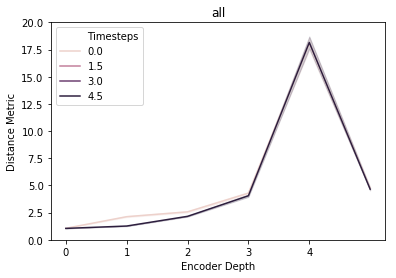

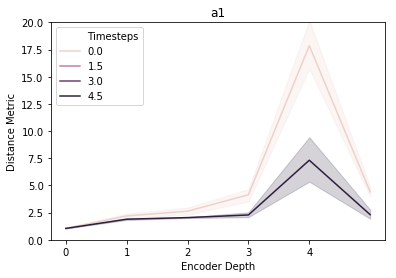

In [39]:
for pnet_name in args:
    pfiles = [
        k for k in os.listdir(
            activations_dir) if k.startswith(pnet_name)
        ]
    dfs = []
    for pfile in pfiles:
        with open(f'{activations_dir}{pfile}', 'rb') as f:
            results = pickle.load(f)
        dfs.append(get_df(
            results, cosine_similarity,
            keep_idxs=np.logical_not(net_mistakes),
            ts=[0, 4], shuffle_results=shuffle_results[pnet_name]
            ))
    df = pd.concat(dfs)
    
    fig, ax = plt.subplots()
    g = sns.lineplot(
        x='Encoder Depth', y='Distance Metric', hue='Timesteps',
        data=df[(df['Clean Accuracy'] == True) & (df['Final Accuracy'] == True)]
        )
    plt.xticks([0, 1, 2, 3, 4])
    plt.ylim(0, 20)
    plt.title(pnet_name)
    #plt.axhline(1, color='gray', linestyle='--')
    plt.show(g)

## FF incorrect, predictive got incorrect, SHUFFLE CORRECTED

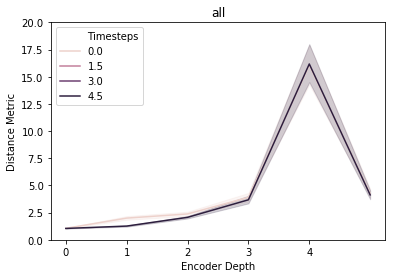

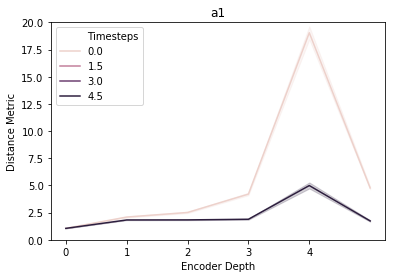

In [40]:
for pnet_name in args:
    pfiles = [
        k for k in os.listdir(
            activations_dir) if k.startswith(pnet_name)
        ]
    dfs = []
    for pfile in pfiles:
        with open(f'{activations_dir}{pfile}', 'rb') as f:
            results = pickle.load(f)
        dfs.append(get_df(
            results, cosine_similarity,
            keep_idxs=np.logical_not(net_mistakes),
            ts=[0, 4], shuffle_results=shuffle_results[pnet_name]
            ))
    df = pd.concat(dfs)
    
    fig, ax = plt.subplots()
    g = sns.lineplot(
        x='Encoder Depth', y='Distance Metric', hue='Timesteps',
        data=df[(df['Clean Accuracy'] == True) & (df['Final Accuracy'] == False)]
        )
    plt.xticks([0, 1, 2, 3, 4])
    plt.ylim(0, 20)
    plt.title(pnet_name)
    #plt.axhline(1, color='gray', linestyle='--')
    plt.show(g)

# Clean is Incorrect

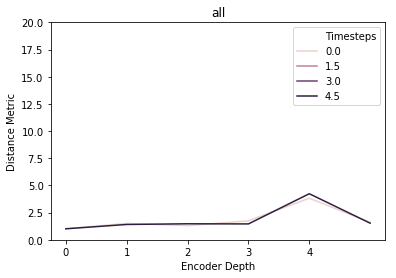

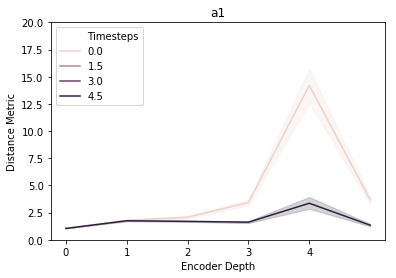

In [41]:
for pnet_name in args:
    pfiles = [
        k for k in os.listdir(
            activations_dir) if k.startswith(pnet_name)
        ]
    dfs = []
    for pfile in pfiles:
        with open(f'{activations_dir}{pfile}', 'rb') as f:
            results = pickle.load(f)
        dfs.append(get_df(
            results, cosine_similarity,
            keep_idxs=net_mistakes,
            ts=[0, 4], shuffle_results=shuffle_results[pnet_name]
            ))
    df = pd.concat(dfs)
    
    fig, ax = plt.subplots()
    g = sns.lineplot(
        x='Encoder Depth', y='Distance Metric', hue='Timesteps',
        data=df[(df['Clean Accuracy'] == False) & (df['Final Accuracy'] == True)]
        )
    plt.xticks([0, 1, 2, 3, 4])
    plt.ylim(0, 20)
    plt.title(pnet_name)
    #plt.axhline(1, color='gray', linestyle='--')
    plt.show(g)